In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from calculate_AQI.aqi_limits import AQI_limits
from calculate_AQI.get_aqi import get_AQI

## Load Dataset and drop rows in which no values are present, Define column 'Epoch' to be equal to the hours since Epoch (same as Index of Rows)

In [2]:
air_quality_dataset = pd.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15))

air_quality_dataset.dropna(inplace=True)

epoch = pd.Timestamp("2004-03-10 18:00:00")

air_quality_dataset['DateTime'] = pd.to_datetime(air_quality_dataset['Date'] + ' ' + air_quality_dataset['Time'], format='%d/%m/%Y %H.%M.%S')
air_quality_dataset['Epoch'] = (air_quality_dataset['DateTime'] - epoch) // pd.Timedelta('1h')

### Analyze Missing Data
* There are a lot of rows in which atleast one column is NaN
* Looking at the columns, it seems that it is best to interpolate the missing data

In [3]:
air_quality_dataset.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Epoch
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604,2004-09-21 16:00:00,4678.000000
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,2004-03-10 18:00:00,0.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,2004-06-16 05:00:00,2339.000000
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,2004-09-21 16:00:00,4678.000000
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,2004-12-28 03:00:00,7017.000000
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,2005-04-04 14:00:00,9356.000000
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670,NaN,2701.277568


In [4]:
air_quality_dataset.replace(to_replace=-200, value=np.nan, inplace=True)
nan_rows = air_quality_dataset.isna().any(axis=1)

air_quality_dataset
air_quality_dataset[nan_rows]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Epoch
9,11/03/2004,03.00.00,0.6,1010.0,19.0,1.7,561.0,NaN,1705.0,NaN,1235.0,501.0,10.3,60.2,0.7517,2004-03-11 03:00:00,9
10,11/03/2004,04.00.00,NaN,1011.0,14.0,1.3,527.0,21.0,1818.0,34.0,1197.0,445.0,10.1,60.5,0.7465,2004-03-11 04:00:00,10
33,12/03/2004,03.00.00,0.8,889.0,21.0,1.9,574.0,NaN,1680.0,NaN,1187.0,512.0,7.0,62.3,0.6261,2004-03-12 03:00:00,33
34,12/03/2004,04.00.00,NaN,831.0,10.0,1.1,506.0,21.0,1893.0,32.0,1134.0,384.0,6.1,65.9,0.6248,2004-03-12 04:00:00,34
39,12/03/2004,09.00.00,NaN,1545.0,NaN,22.1,1353.0,NaN,767.0,NaN,2058.0,1588.0,9.2,56.2,0.6561,2004-03-12 09:00:00,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,2005-04-04 10:00:00,9352
9353,04/04/2005,11.00.00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,2005-04-04 11:00:00,9353
9354,04/04/2005,12.00.00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,2005-04-04 12:00:00,9354
9355,04/04/2005,13.00.00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,2005-04-04 13:00:00,9355


* The NMHC Column has a lot of NaN values, But it still maybe useful in calculating AQI if it is not NaN

## Calculating AQI According to Ground Truth Details and US EPA Standards

In [5]:
ground_truth_features = AQI_limits.keys()


In [6]:
air_quality_dataset[ground_truth_features]

,CO(GT),NOx(GT),NO2(GT),NMHC(GT),C6H6(GT)
0,2.6,166.0,113.0,150.0,11.9
1,2.0,103.0,92.0,112.0,9.4
2,2.2,131.0,114.0,88.0,9.0
3,2.2,172.0,122.0,80.0,9.2
4,1.6,131.0,116.0,51.0,6.5
...,...,...,...,...,...
9352,3.1,472.0,190.0,NaN,13.5
9353,2.4,353.0,179.0,NaN,11.4
9354,2.4,293.0,175.0,NaN,12.4
9355,2.1,235.0,156.0,NaN,9.5


* looking at the data, it seems that the following rows: [1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4360, ..., 4362, 4363, 4364, 4365, 4366] (31 rows) do not mention the ground truth values of any of the pollutants
* We cannot really label these rows. Hence, we can drop these rows

In [7]:
null_ground_truth_features = air_quality_dataset[ground_truth_features].isnull().all(axis=1)
print('number of fully Null ground truth features: ', null_ground_truth_features.sum())
air_quality_dataset = air_quality_dataset[~null_ground_truth_features]
air_quality_dataset.reset_index(drop=True, inplace=True)

number of fully Null ground truth features:  31


* It seems to be the case that entries under similar Month and Hour have similar concentrations of pollutants

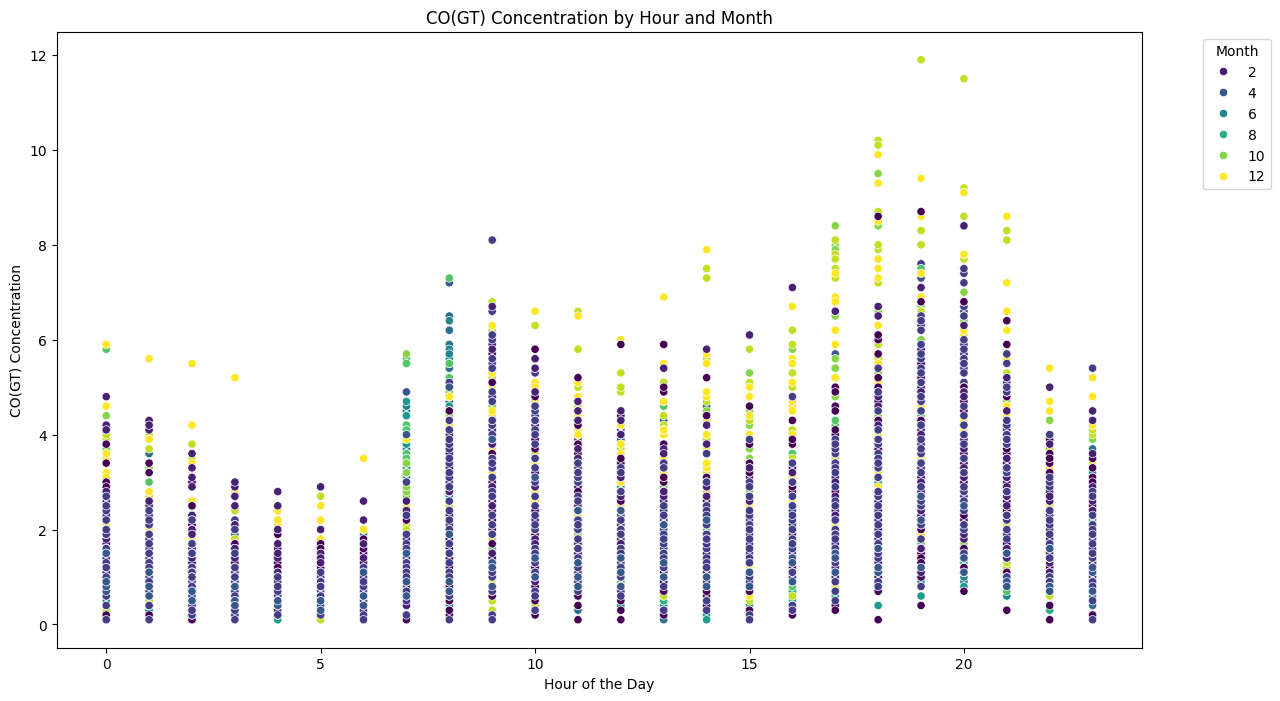

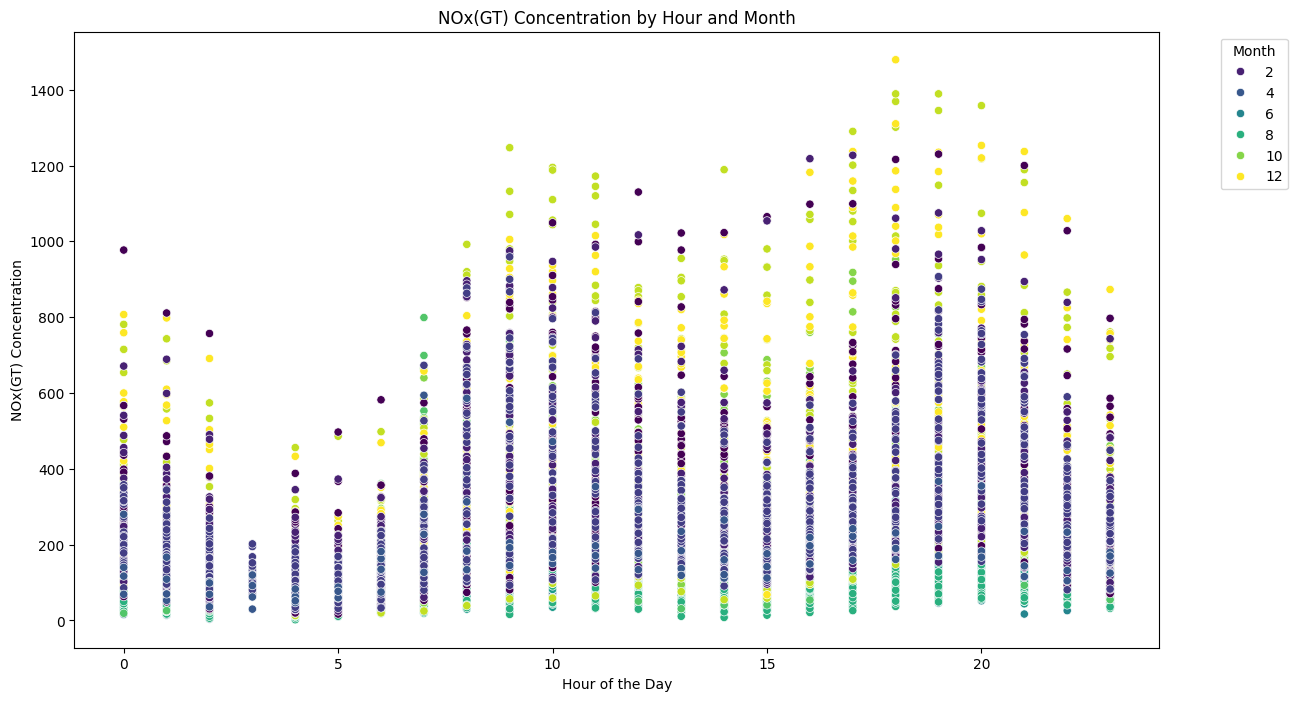

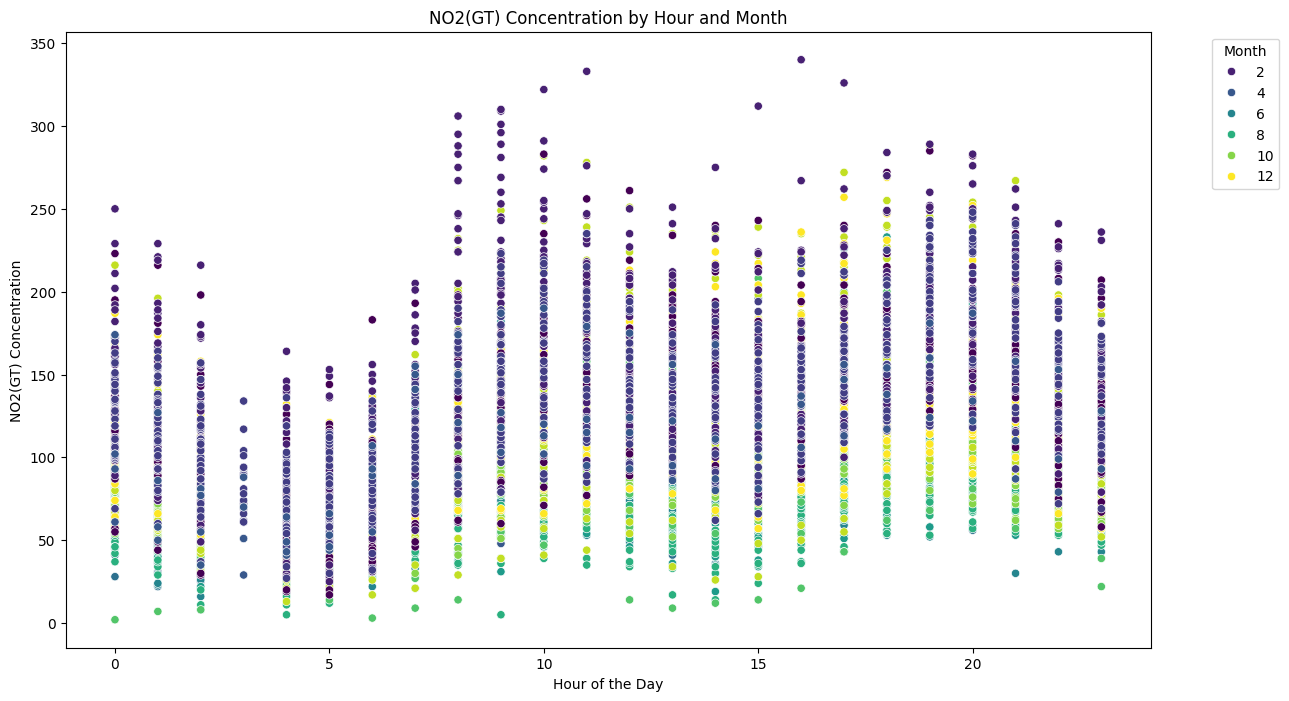

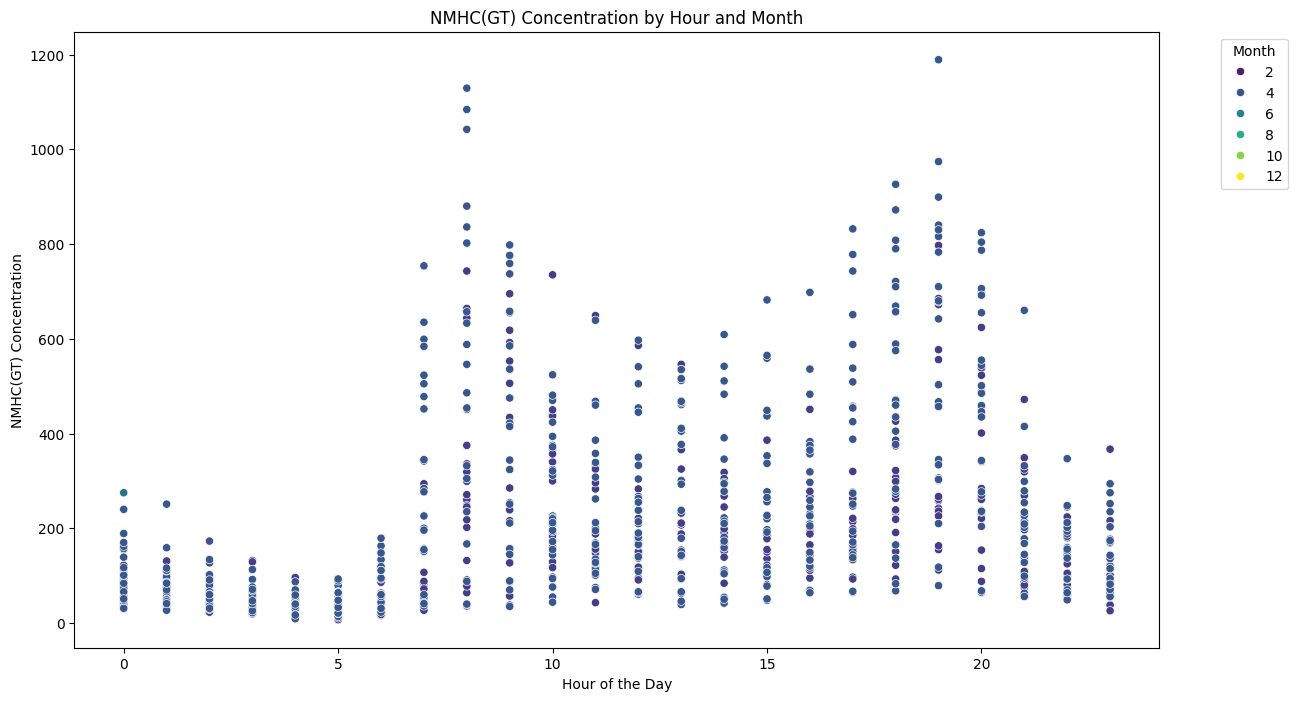

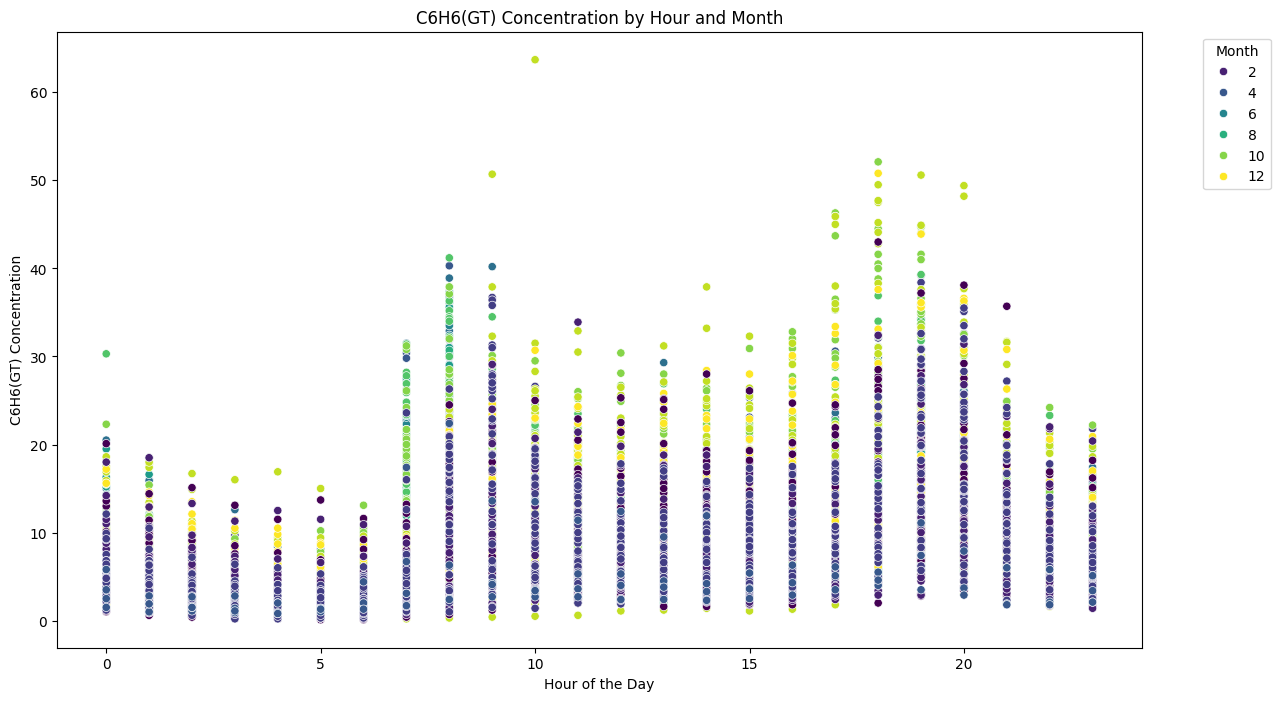

In [8]:
# Assuming air_quality_dataset is your DataFrame and 'DateTime' is your DateTime column
air_quality_dataset['DateTime'] = pd.to_datetime(air_quality_dataset['DateTime'])

# Extract month and hour from the DateTime column
air_quality_dataset['Month'] = air_quality_dataset['DateTime'].dt.month
air_quality_dataset['Hour'] = air_quality_dataset['DateTime'].dt.hour

for feature in ground_truth_features:
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x='Hour', y=feature, hue='Month', data=air_quality_dataset, palette='viridis')
    plt.xlabel('Hour of the Day')
    plt.ylabel(f'{feature} Concentration')
    plt.title(f'{feature} Concentration by Hour and Month')
    plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

* We can impute the values of the missing features using an approximation based on similar month or hour

In [9]:
for feature in ground_truth_features:
    air_quality_dataset[feature]=air_quality_dataset[feature].fillna(air_quality_dataset.groupby(['Month', 'Hour'])[feature].transform('mean'))
    air_quality_dataset[feature]=air_quality_dataset[feature].fillna(air_quality_dataset.groupby(['Hour'])[feature].transform('mean'))

In [10]:
air_quality_dataset['AQI'] = air_quality_dataset[ground_truth_features].apply(lambda x: get_AQI(x, AQI_limits), axis=1)
len(air_quality_dataset)

9326

## Let us analyze the dataset further

In [11]:
air_quality_dataset.describe()

training_features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
# Adding the Epoch column seems to increase accuracy of out model. This has something to do with the change in AQI over time
null_training_features = air_quality_dataset[training_features].isnull().all(axis=1)
training_features.append('Epoch')
print(null_training_features)
print(f"Number of rows where all training features are null: {null_training_features.sum()}")

0       False
1       False
2       False
3       False
4       False
        ...  
9321    False
9322    False
9323    False
9324    False
9325    False
Length: 9326, dtype: bool
Number of rows where all training features are null: 335


* It seems that there are 335 rows which have all of the training features as null,
* We have 9326 rows for which we can define a AQI using any of the pollutants
* Also, we have the number of non-NaN values in each of the training features as 8991. 
* This implies that After we drop these 335 columns, All of the remaining rows have defined values of the training features

In [12]:
air_quality_dataset = air_quality_dataset[~null_training_features]
air_quality_dataset.reset_index(drop=True, inplace=True)

In [13]:
air_quality_dataset.describe()
print(len(air_quality_dataset))


8991


By Now, The dataset is in a position to be feeded to our model

* Since the values of all features seem to be in different ranges, we use the Z-Score of the values in order to train our model

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

training_label = 'AQI'

X = air_quality_dataset[training_features]
y = air_quality_dataset[training_label]

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)))


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 7642
Testing set size: 674
Validation set size: 675


* Our Model is a simple Regression model with three fully connected layers and an added drouput regularization after the last connected layer.

* It is seen that the model performs best with a learning rate of 0.0005 and using the Stochastic Gradient Descent optimizer. Using this mode, We are able to obtain an accuracy of 87.1% on the test data.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(128, input_dim=len(training_features), activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=SGD(learning_rate=0.0007, momentum=0.9), loss='mean_squared_error')

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=300, batch_size=50, validation_data=(X_val, y_val), validation_batch_size=32, callbacks=[early_stopping])

Epoch 1/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2267 - val_loss: 1.6745
Epoch 2/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7523 - val_loss: 1.5695
Epoch 3/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6472 - val_loss: 1.4885
Epoch 4/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5642 - val_loss: 1.4219
Epoch 5/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4900 - val_loss: 1.3686
Epoch 6/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4243 - val_loss: 1.3095
Epoch 7/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3736 - val_loss: 1.2565
Epoch 8/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3209 - val_loss: 1.2071
Epoch 9/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2552 - val_loss: 1.1642
Epoch 10/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2229 - val_loss: 1.1186
Epoch 11/300
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1712 - val_loss: 1.0787
Epoch 12/300
153/153 ━━━━━━━━━━━━━━━━━━━━

In [18]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

predictions = model.predict(X_test)
print(predictions)
r2 = r2_score(y_test, predictions)
print(f"R^2 Score: {r2}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1648 
Test Loss: 0.15645362436771393
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[ 1.05237514e-01]
 [-3.40782940e-01]
 [-4.15970385e-01]
 [-5.21482110e-01]
 [-9.62525427e-01]
 [-7.69631088e-01]
 [-6.45846069e-01]
 [ 3.03530693e-03]
 [ 7.06756413e-01]
 [ 9.22267675e-01]
 [ 1.07428694e+00]
 [-8.67020190e-01]
 [ 9.93162692e-01]
 [-4.20313060e-01]
 [ 1.60115540e-01]
 [ 1.12801290e+00]
 [-8.61588776e-01]
 [-6.13933742e-01]
 [ 1.43222123e-01]
 [ 8.24941456e-01]
 [-5.38781703e-01]
 [-7.51225531e-01]
 [-1.77540779e-02]
 [ 4.84680116e-01]
 [ 1.21657991e+00]
 [-8.14842999e-01]
 [ 6.68158472e-01]
 [-8.61713827e-01]
 [-1.21404219e+00]
 [ 2.42890179e-01]
 [ 4.55054522e-01]
 [ 1.24240375e+00]
 [ 1.04052663e+00]
 [ 1.30220819e+00]
 [-4.85948205e-01]
 [-4.71694648e-01]
 [ 4.17884290e-02]
 [-9.91346240e-02]
 [-7.48716772e-01]
 [ 1.37799025e+00]
 [ 3.38671833e-01]
 [-3.41282189e-01]
 [-8.21381390e-01]
 [ 8.83226871e-01]
 [ 1.35263968e+00]
 [-4.92819130e-01]


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


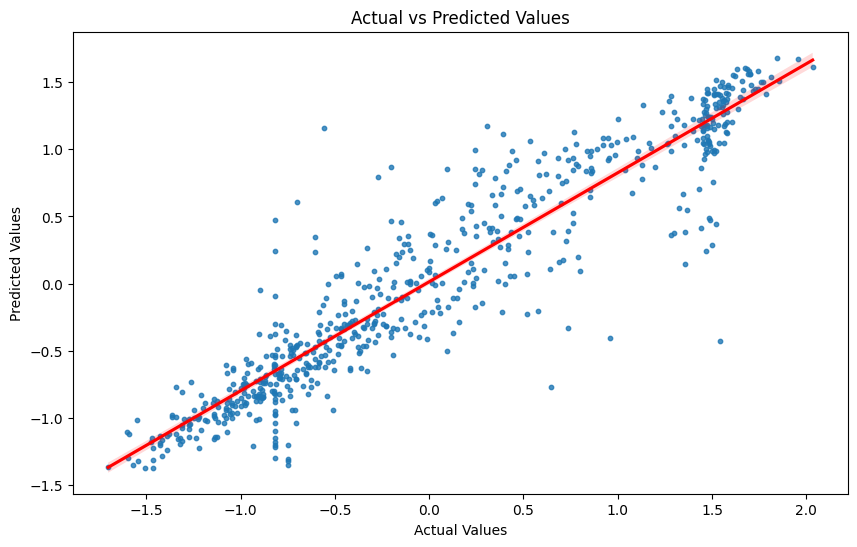

In [19]:
import seaborn as sns

predictions = model.predict(X_test)

import pandas as pd
results = pd.DataFrame({'Actual': y_test.to_numpy().flatten(), 'Predicted': predictions.flatten()})

# Plot the regression plot
plt.figure(figsize=(10, 6))
sns.regplot(x='Actual', y='Predicted', data=results, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Text(0.5, 1.0, 'Model Loss-Epoch curve')

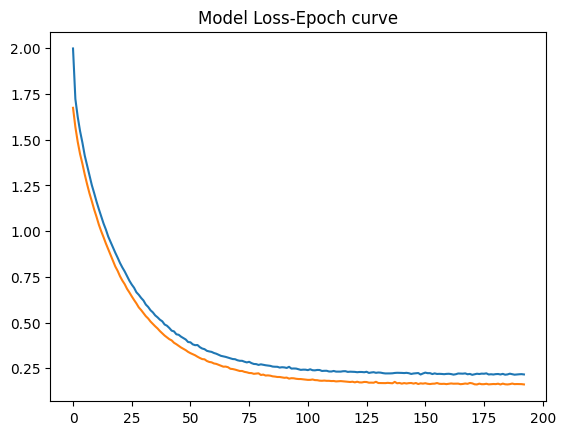

In [20]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss-Epoch curve')